## Project Title: Face Mask Detection with Machine Learning

Objective: The goal of this project is to develop a machine learning model to accurately detect whether individuals are wearing face masks in images. This is particularly relevant in contexts where mask-wearing compliance is essential, such as in public health scenarios.

Project Description: In this project, students will leverage machine learning techniques to build and train a model for face mask detection. The project will involve collecting and preparing data, selecting appropriate algorithms, training the model, and evaluating its performance. The final deliverable will be a model capable of classifying images into categories of "masked" and "unmasked."

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/wobotintelligence/face-mask-detection-dataset/data")

Dataset URL: https://www.kaggle.com/datasets/wobotintelligence/face-mask-detection-dataset


100%|██████████| 2.50G/2.50G [00:24<00:00, 112MB/s] 


In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
import pickle

In [5]:
pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.3 MB/s eta 0:00:00


In [6]:
from mtcnn.mtcnn import MTCNN

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
images = '/content/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images'
annotations = '/content/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations'
train = pd.read_csv('/content/face-mask-detection-dataset/train.csv')
submission = pd.read_csv('/content/face-mask-detection-dataset/submission.csv')

In [10]:
print(len(train))
train.head()

15412


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [11]:
print(len(submission))
submission.head()

8142


,name,x1,x2,y1,y2,classname
0,1800.jpg,NaN,NaN,NaN,NaN,NaN
1,1800.jpg,NaN,NaN,NaN,NaN,NaN
2,1800.jpg,NaN,NaN,NaN,NaN,NaN
3,1799.jpg,NaN,NaN,NaN,NaN,NaN
4,1799.jpg,NaN,NaN,NaN,NaN,NaN


In [12]:
len(os.listdir(images))

6024

In [13]:
a=os.listdir(images)
b=os.listdir(annotations)
a.sort()
b.sort()

In [26]:
train_images=a[1698:]
test_images=a[:1698]

In [27]:
test_images[0]

'0001.jpg'

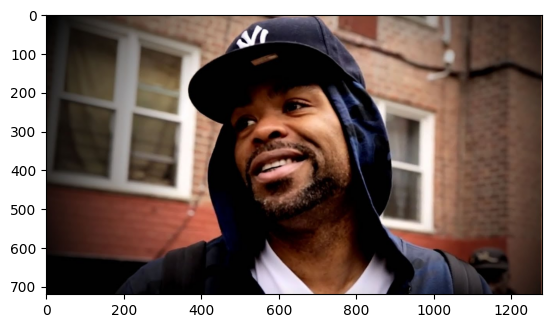

In [28]:
img=plt.imread(os.path.join(images,test_images[0]))
plt.imshow(img)
plt.show()

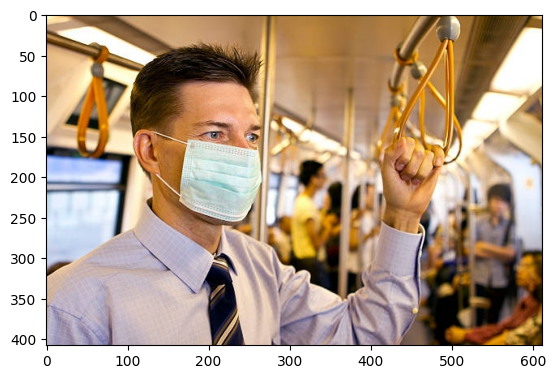

In [29]:
img=plt.imread(os.path.join(images,train_images[1]))
plt.imshow(img)
plt.show()

In [30]:
options=['face_with_mask','face_no_mask']
train= train[train['classname'].isin(options)]
train.sort_values('name',axis=0,inplace=True)

[[112, 113, 262, 307]]


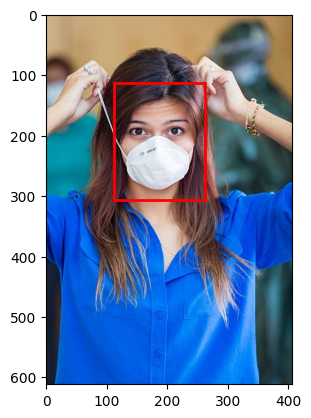

In [31]:
bbox=[]
for i in range(len(train)):
    arr=[]
    for j in train.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train["bbox"]=bbox
def get_boxes(id):
    boxes=[]
    for i in train[train["name"]==str(id)]["bbox"]:
        boxes.append(i)
    return boxes
print(get_boxes(train_images[3]))
image=train_images[3]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

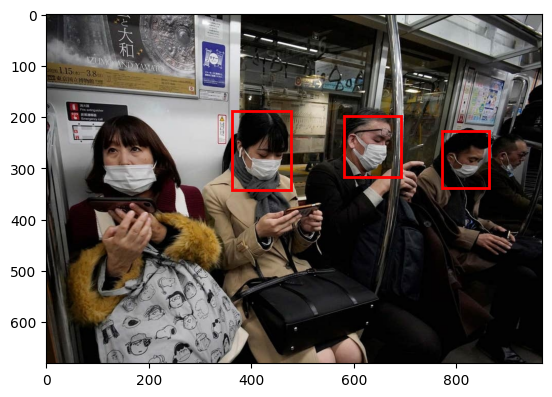

In [32]:
image=train_images[9]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

<BarContainer object of 2 artists>

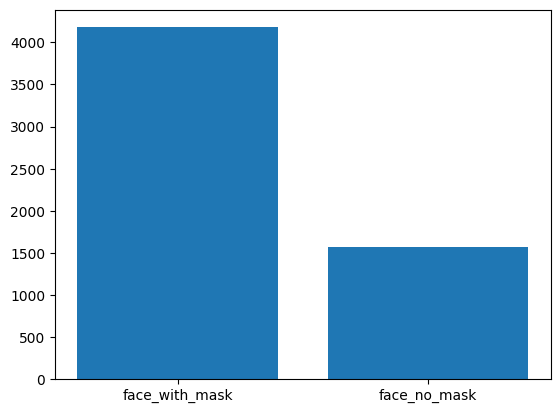

In [33]:
plt.bar(['face_with_mask','face_no_mask'],train.classname.value_counts())

In [34]:
# Ensure data consistency by checking lengths during data creation
img_size = 50
data = []

def create_data():
    for i in range(len(train)):
        arr = []
        for j in train.iloc[i]:
            arr.append(j)

        img_array = cv2.imread(os.path.join(images, arr[0]), cv2.IMREAD_GRAYSCALE)

        # Ensure image exists
        if img_array is not None:
            crop_image = img_array[arr[2]:arr[4], arr[1]:arr[3]]
            new_img_array = cv2.resize(crop_image, (img_size, img_size))
            data.append([new_img_array, arr[5]])

create_data()

# Split features and labels
x = []
y = []
for features, labels in data:
    x.append(features)
    y.append(labels)

# Check if the lengths are consistent
print(f'Length of x: {len(x)}')
print(f'Length of y: {len(y)}')

# Proceed with reshaping and encoding
x = np.array(x).reshape(-1, img_size, img_size, 1)
x = tf.keras.utils.normalize(x, axis=1)

Length of x: 5749
Length of y: 5749


In [35]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# Encode labels
lbl = LabelEncoder()
y = lbl.fit_transform(y)
y = to_categorical(y)

# Check shapes of x and y again
print(f'Shape of x: {x.shape}')
print(f'Shape of y: {y.shape}')


Shape of x: (5749, 50, 50, 1)
Shape of y: (5749, 2)


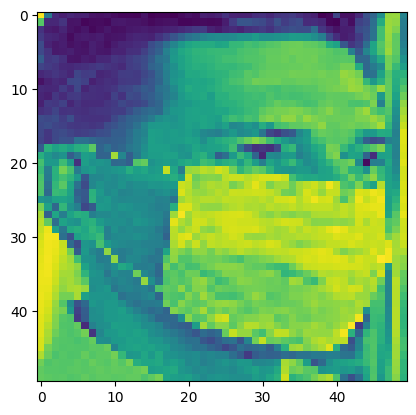

In [36]:
data[1][0]
plt.imshow(data[1][0])

In [37]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

from keras.layers import LSTM
model=Sequential()
model.add(Conv2D(100,(3,3),activation='relu',strides=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
# Train-test split
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# Fit the model
history = model.fit(X_train, y_train, epochs=5, batch_size=5, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.7147 - loss: 0.5969 - val_accuracy: 0.7296 - val_loss: 0.5435
Epoch 2/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.7328 - loss: 0.4901 - val_accuracy: 0.7783 - val_loss: 0.4492
Epoch 3/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.7915 - loss: 0.4610 - val_accuracy: 0.8000 - val_loss: 0.4290
Epoch 4/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8063 - loss: 0.4332 - val_accuracy: 0.8261 - val_loss: 0.3882
Epoch 5/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8253 - loss: 0.3917 - val_accuracy: 0.8452 - val_loss: 0.3533


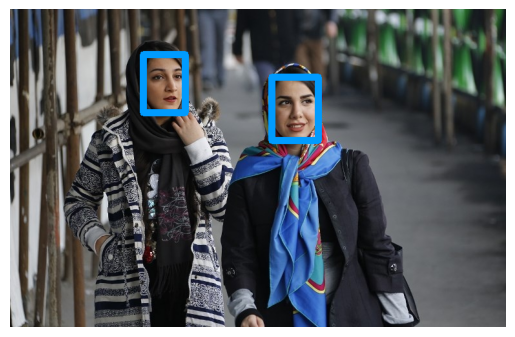

In [40]:
import cv2
from matplotlib import pyplot as plt
from mtcnn import MTCNN
import numpy as np
import os

detector = MTCNN()

# Load the image
img = plt.imread(os.path.join(images, test_images[9]))

# Detect faces
faces = detector.detect_faces(img)

# Make a writable copy of the image
img_copy = np.copy(img)

# Draw rectangles around detected faces
for face in faces:
    bounding_box = face['box']
    x = cv2.rectangle(img_copy,
                      (bounding_box[0], bounding_box[1]),
                      (bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]),
                      (0, 155, 255),
                      10)

# Display the image with the rectangle(s)
plt.imshow(img_copy)
plt.axis('off')  # Hide axes for a cleaner display
plt.show()

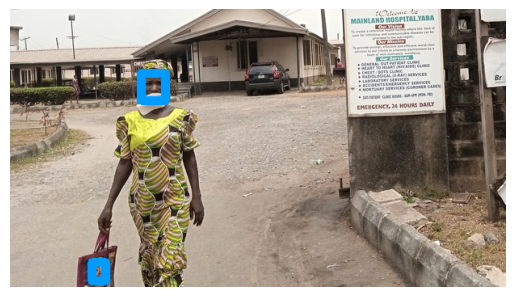

In [41]:
# Load the image
img = plt.imread(os.path.join(images, test_images[17]))

# Detect faces
faces = detector.detect_faces(img)

# Make a writable copy of the image
img_copy = np.copy(img)

# Draw rectangles around detected faces
for face in faces:
    bounding_box = face['box']
    x = cv2.rectangle(img_copy,
                      (bounding_box[0], bounding_box[1]),
                      (bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]),
                      (0, 155, 255),
                      10)

# Display the image with the rectangle(s)
plt.imshow(img_copy)
plt.axis('off')  # Hide axes for a cleaner display
plt.show()

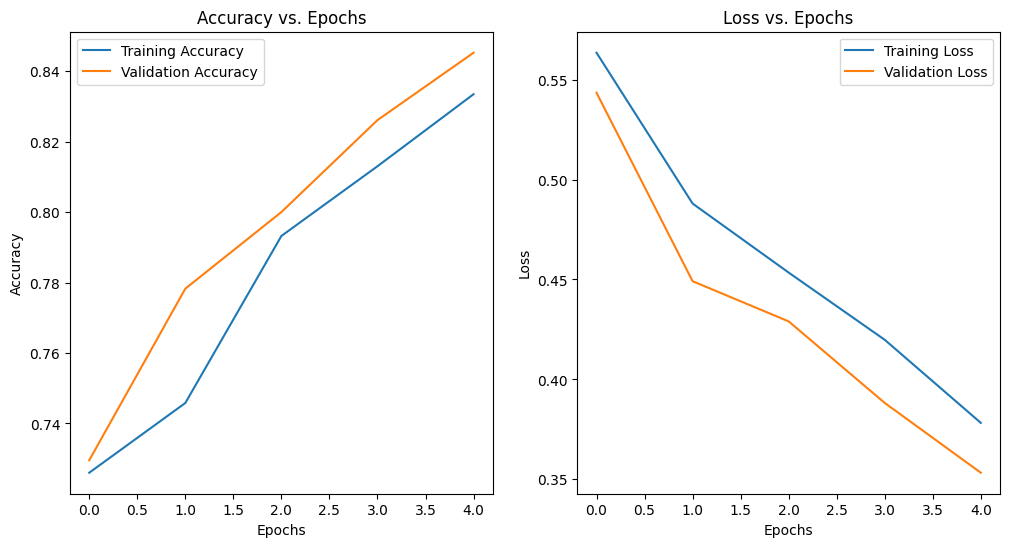

In [42]:
# Plot Accuracy vs. Loss Curves
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

plt.show()

In [43]:
# Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=['face_with_mask', 'face_no_mask']))

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Classification Report:
                 precision    recall  f1-score   support

face_with_mask       0.75      0.64      0.69       311
  face_no_mask       0.87      0.92      0.90       839

      accuracy                           0.85      1150
     macro avg       0.81      0.78      0.79      1150
  weighted avg       0.84      0.85      0.84      1150



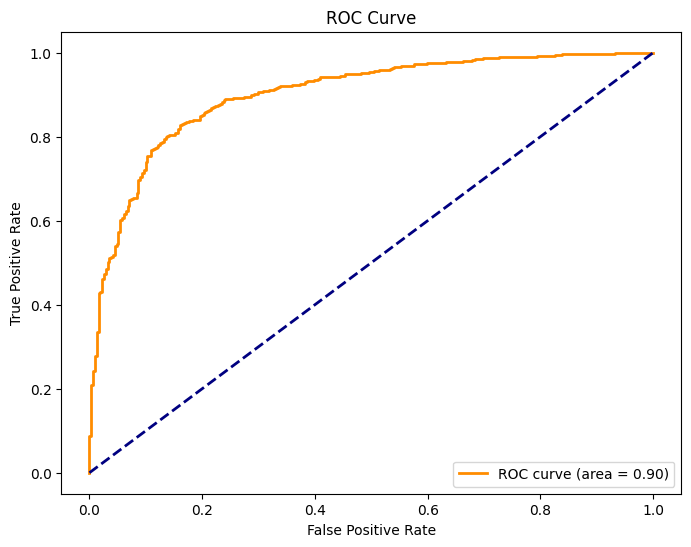

In [44]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])  # Use probabilities for class 1 (face_no_mask)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [45]:
import sklearn
import pickle

In [46]:
# print versions of libraries
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("OpenCV version:", cv2.__version__)
print("scikit-learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)

NumPy version: 1.26.4
Pandas version: 2.2.2
OpenCV version: 4.10.0
scikit-learn version: 1.5.2
TensorFlow version: 2.17.0


In [47]:
with open('model2.pkl', 'wb') as file:
    pickle.dump(model, file)